In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import src.data.organize_data as od

features_list = ['t0', 't1', 't2', 'a0', 'a1', 'a2', 'b0', 'b1', 'b2', 'c0', 'c1', 'c2', 'dicnotch', 'winSys', 'maxAmpl', 'sysTime', 'duration',  'Es', 'As', 'Ed', 'Ad', 'td', 'fd', 'R2_of_fit']
feature_data_path  = r"C:\Users\cical\Documents\GitHub\Repositories\tesina\data\interim\feature_extracted"

feature_df = od.organize_data2(feature_data_path, features_list)

c:\Users\cical\Documents\GitHub\Repositories\tesina\src\data\organize_data.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, data_df], ignore_index=True)


# Data Pre-Processing

## Split Dataset

In [3]:
import src.data.organize_data as od

X_train, X_test, y_train, y_test = od.split_train_test(feature_df, 'Group', 0.2)

Group


## Data selection (outliers and p-value)

In [4]:
import src.data.data_selection as ds

X_train, y_train = ds.filter_outliers_by_group(X_train, y_train, features_to_ignore=['PatientID', 'SignalID', 'R2_of_fit', 'pulse_index'])

X_train, y_train = ds.filter_fit_value(X_train, y_train, 0.9, 'R2_of_fit')

INFO:root:Removed 688 rows for label covid_Empoli_60
INFO:root:Removed 990 rows for label healthyControl_Empoli_60
INFO:root:Removed 6259 rows for label mentalDisorders_MIMIC_125
INFO:root:Removed 4776 rows for label sepsis_MIMIC_125


## Data Trasformation

### Patient median

In [5]:
import src.data.data_preprocessing as dp

X_train, y_train = dp.calculate_patient_median(X_train, y_train, 'SignalID', features_list)
X_test, y_test = dp.calculate_patient_median(X_test, y_test, 'SignalID', features_list)


X_train.drop(columns=['SignalID',  'R2_of_fit'], inplace=True)
X_test.drop(columns=['SignalID',   'R2_of_fit'], inplace=True)

### SMOTE+EEN

In [6]:
import src.data.data_preprocessing as dp
import src.visualization.visualize as vis

#vis.plot_class_distribution(y_train, title="Distribution before SMOTEEN")

#X_train, y_train = dp.balance_dataset(X_train, y_train)

#vis.plot_class_distribution(y_train, title="Distribution after SMOTEEN")

### Scaling


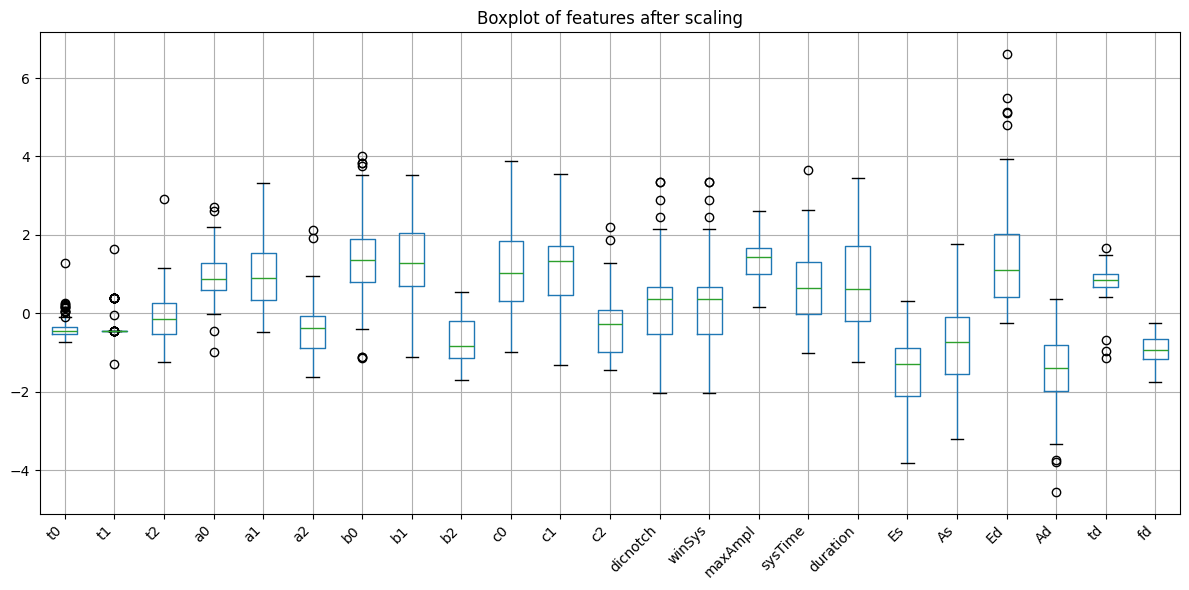

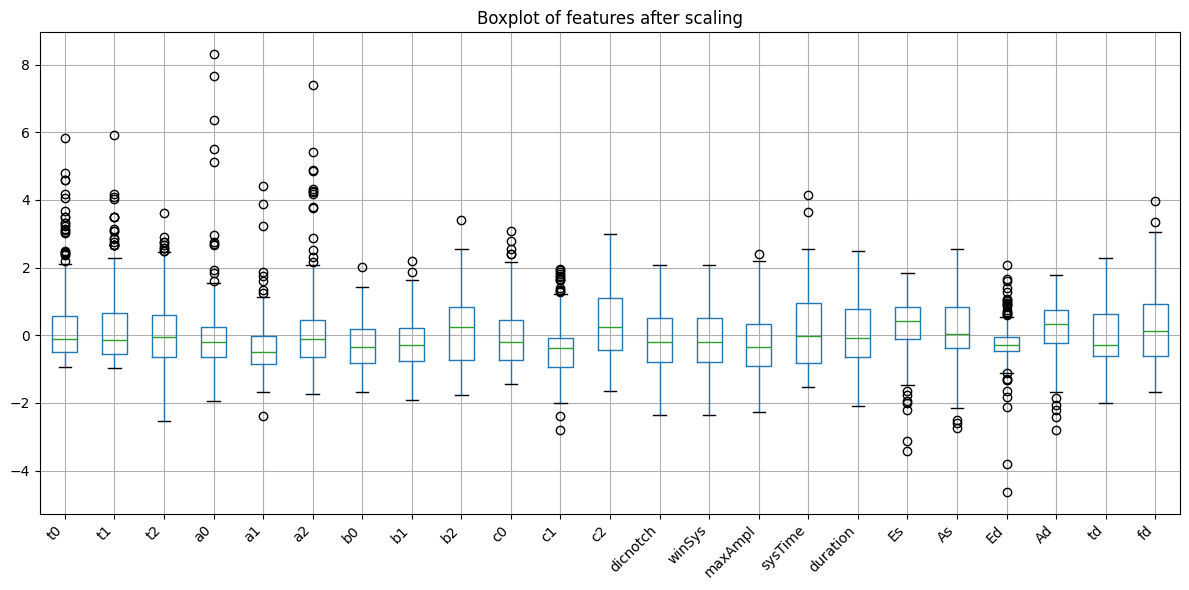

In [33]:
import src.data.data_preprocessing as dp
import src.visualization.visualize as vis

X_train = dp.scale_numeric_features(X_train)
X_test = dp.scale_numeric_features(X_test)

df = X_train.copy()
df['Group'] = y_train

# Statistical tests

## Shapiro-Wilk test

c:\Users\cical\Documents\GitHub\Repositories\tesina\src\statistics\tests_normality.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': stat, 'P-value': p_value}])], ignore_index=True)


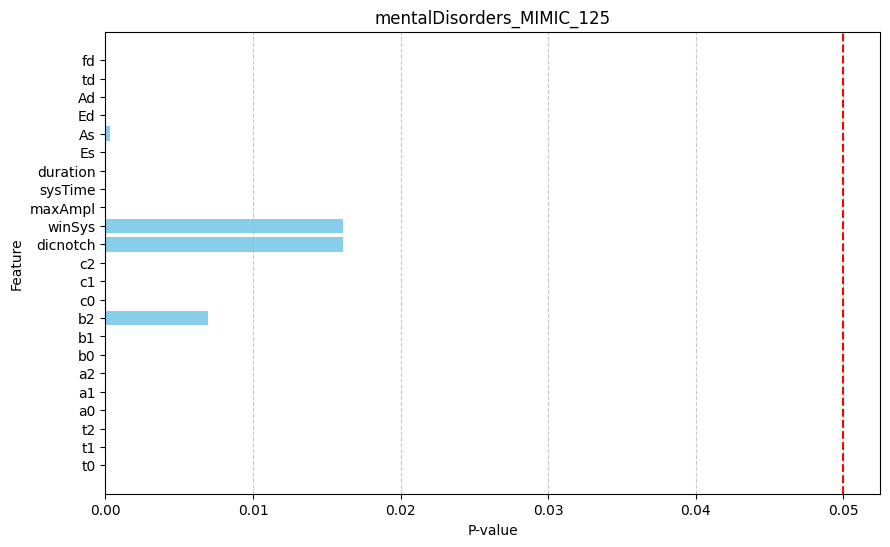

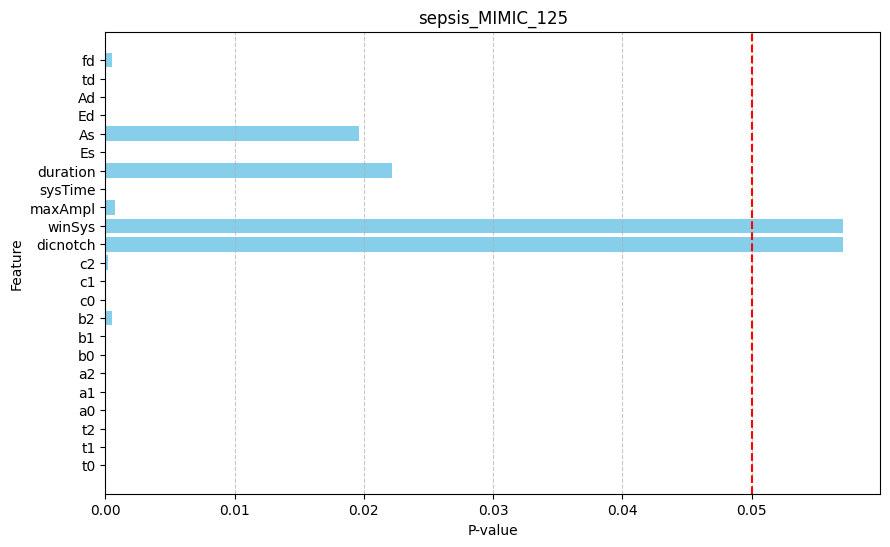

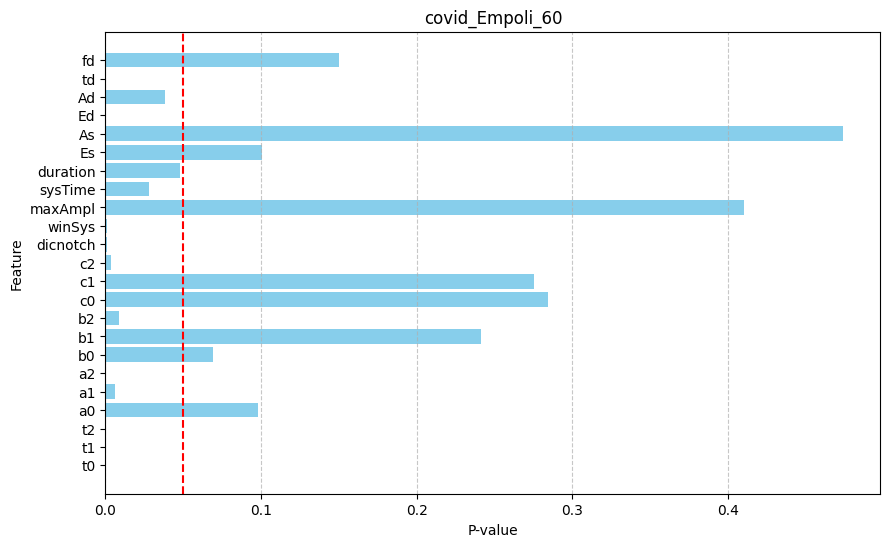

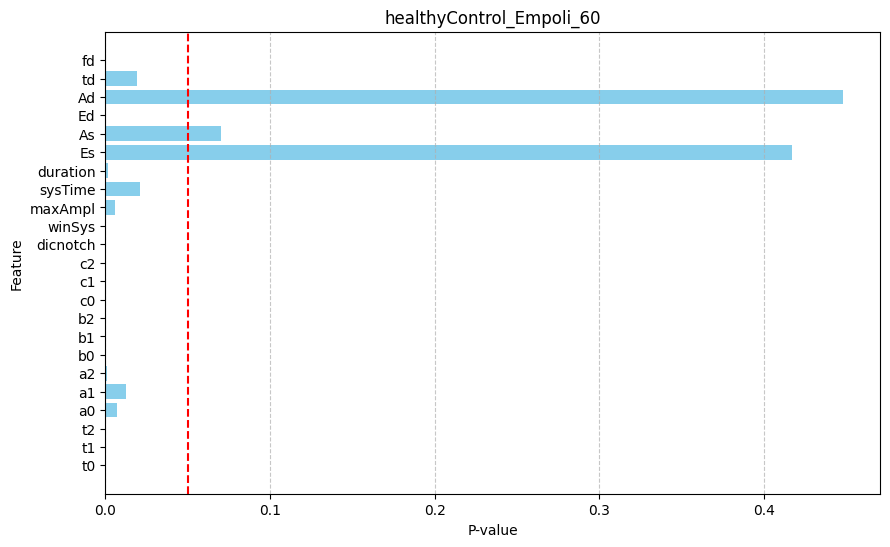

In [8]:
import src.statistics.tests_normality as nt
import src.visualization.visualize as vis

normality_test = nt.shapiro_test(X_train, y_train)

for group in normality_test['Group'].unique():
    sub_df = normality_test[normality_test['Group'] == group]
    vis.plot_pvalues(sub_df, group)

## Friedman test

c:\Users\cical\Documents\GitHub\Repositories\tesina\src\statistics\tests_difference.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': f_statistic, 'P-value': p_value}])], ignore_index=True)


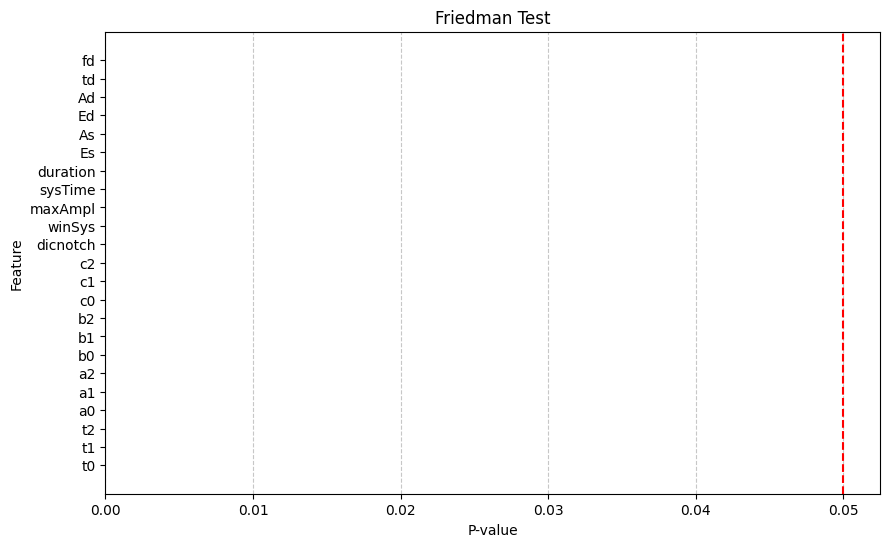

In [9]:
import src.statistics.tests_difference as td
import src.visualization.visualize as vis

friedman_test = td.friedman_test(X_train, y_train)

vis.plot_pvalues(friedman_test, 'Friedman Test')


## Post-hoc Mann-Whitney U

In [10]:
import src.statistics.tests_difference as td

# valuto differenze tra gruppi per le features significative del test di Friedman
significant_features = friedman_test[friedman_test['P-value'] < 0.05]['Feature'].tolist()
significant_features_dict = td.pairwise_mann_whitney_test(X_train, y_train, significant_features=significant_features)

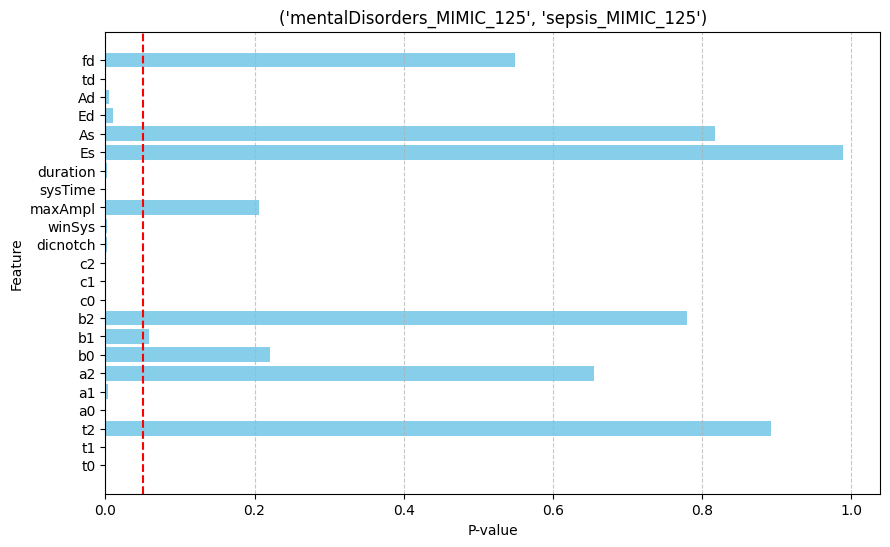

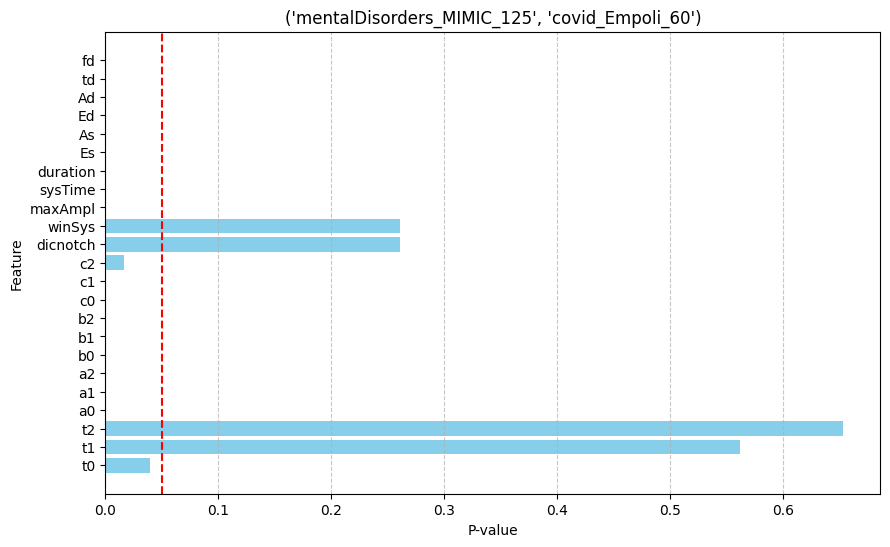

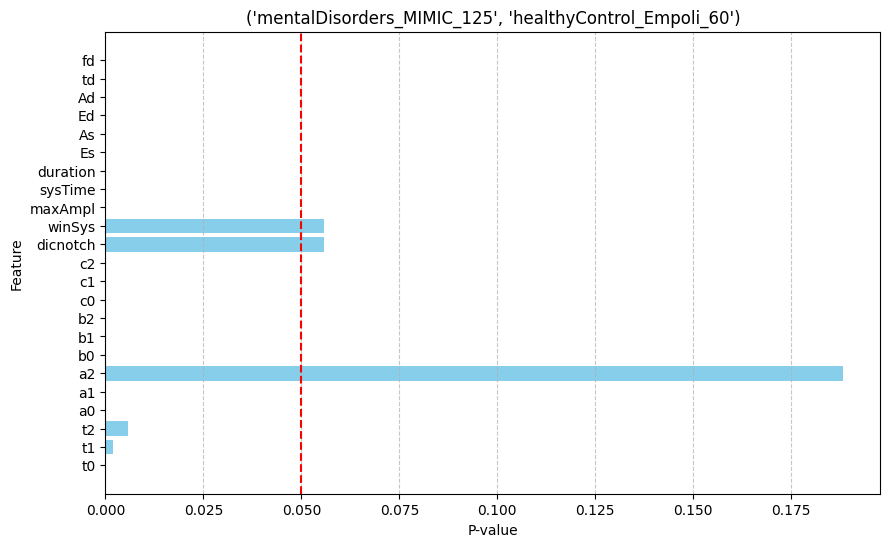

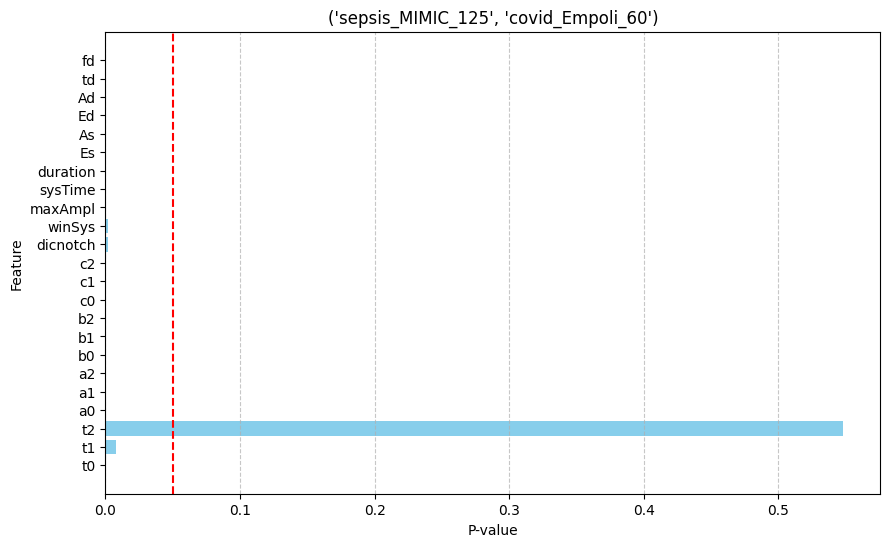

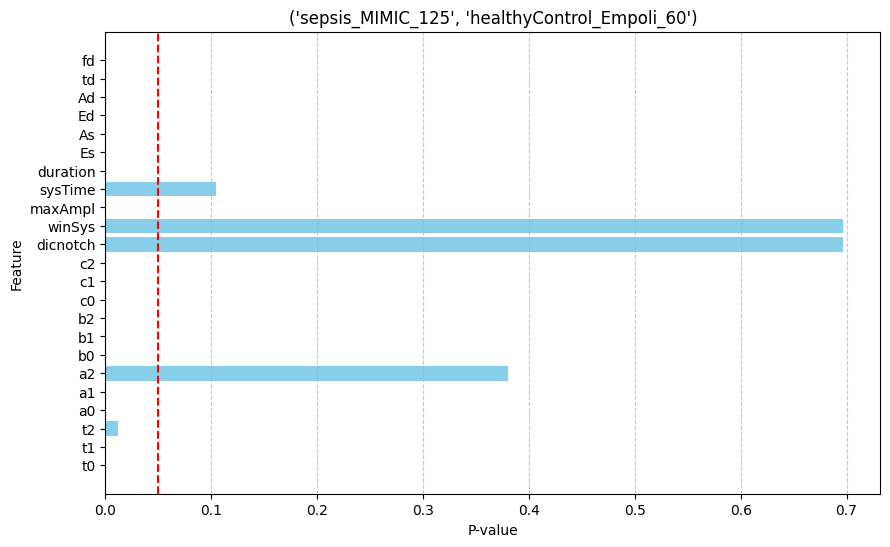

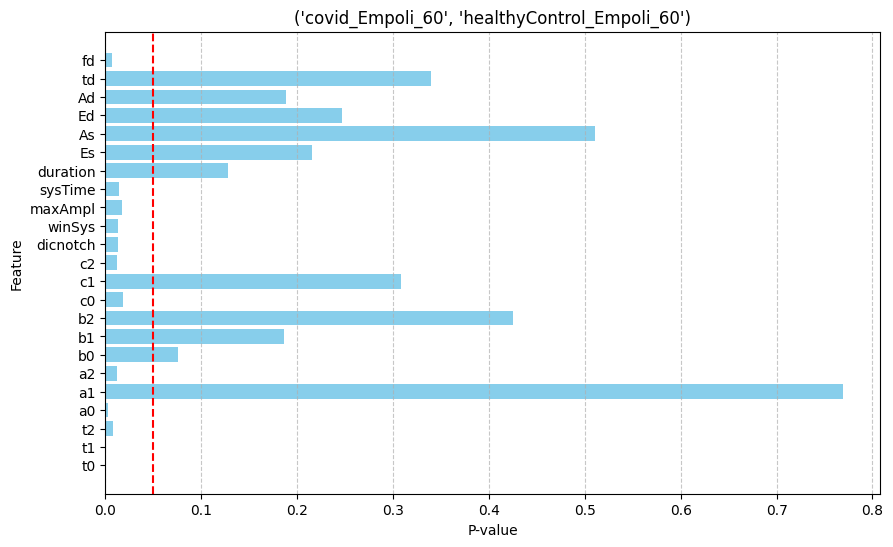

In [11]:
import src.visualization.visualize as vis

for group_pair, result in significant_features_dict.items():
    vis.plot_pvalues(result, group_pair)

## Unified dataset

Si cercano differenze tra il gruppo di sani (health e soggetti con disturbi mentali) e il gruppo di malati (sepsi e covid)

c:\Users\cical\Documents\GitHub\Repositories\tesina\src\statistics\tests_difference.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': u_statistic, 'P-value': p_value}])], ignore_index=True)


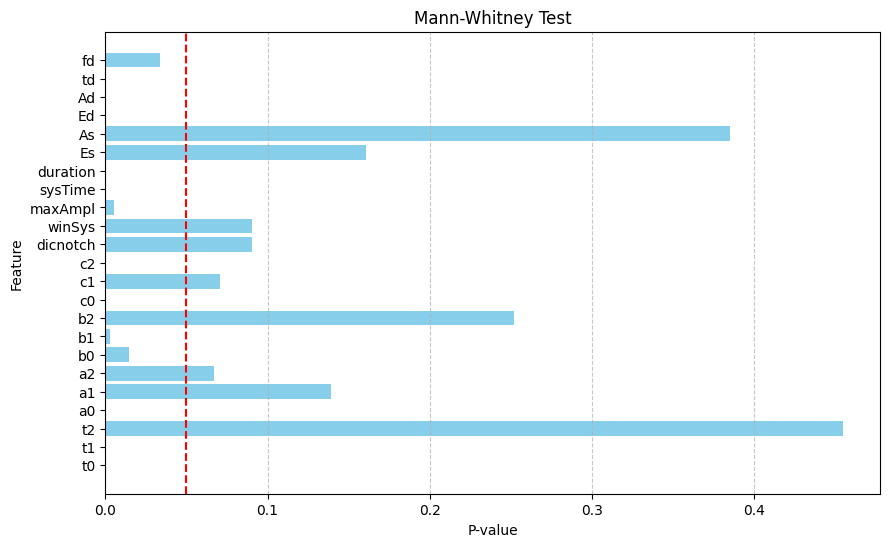

In [12]:
import src.statistics.tests_difference as td
import src.visualization.visualize as vis

y_train_unified = y_train.copy()

# Mappa i valori della colonna 'Group' come richiesto
mapping = {'covid_Empoli_60': "sick", 'sepsis_MIMIC_125': "sick",
           'healthyControl_Empoli_60': "healthy", 'mentalDisorders_MIMIC_125': "healthy"}
y_train_unified = y_train_unified.replace(mapping)

unified_result = td.mann_whitney_test(X_train, y_train_unified)

vis.plot_pvalues(unified_result, 'Mann-Whitney Test')

# Training Model

## Primo test (Health vs Ill)

Nel primo test si cerca di addestrare un modello che permetta di identificare tra gruppo di sani (heamth and mental disorders) e patologici (covid o sepsi). 
A questo scopo vengono utilizzate le features con un valore di p-value al di sotto della soglia impostata del test di mann-Whitney per il dataset unificato.

In [13]:
features_test_1 = unified_result[unified_result['P-value'] < 0.05]['Feature'].tolist()

X_train_t1 = X_train[features_test_1]
X_test_t1 = X_test[features_test_1]

y_train_t1 = y_train.map({'covid_Empoli_60': 0, 'sepsis_MIMIC_125': 0, 
                              'healthyControl_Empoli_60': 1, 'mentalDisorders_MIMIC_125': 1})

y_test_t1 = y_test.map({'covid_Empoli_60': 0, 'sepsis_MIMIC_125': 0, 
                              'healthyControl_Empoli_60': 1, 'mentalDisorders_MIMIC_125': 1})

### Cross validation

Si effettua una cross validazione con StratifiedKFold (cv=5) e si valutano le performance dei modelli per f1_macro e il coeff. di correlazioen di Matthews. I tre modelli che presentano le prestazioni migliori veranno poi migliorati con un ottizzazione degli iperparametri.

In [14]:
import src.models.model as models
import src.models.evaluation as ev

models = models.define_models()
metric_results = ev.evaluate_models(X_train_t1, y_train_t1, models)

ev.summarize_results(metric_results)

Models Evaluation with f1_macro: 100%|██████████| 9/9 [00:12<00:00,  1.36s/it]
Models Evaluation with make_scorer(matthews_corrcoef, response_method='predict'): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Metric: f1_macro
Rank=1, Name=catboost, Score=0.736 (+/- 0.028)
Rank=2, Name=rf, Score=0.714 (+/- 0.030)
Rank=3, Name=mlp, Score=0.698 (+/- 0.040)
Rank=4, Name=gbm, Score=0.694 (+/- 0.028)
Rank=5, Name=adaboost, Score=0.667 (+/- 0.014)
Rank=6, Name=dt, Score=0.660 (+/- 0.046)
Rank=7, Name=svm, Score=0.659 (+/- 0.051)
Rank=8, Name=nb, Score=0.598 (+/- 0.046)
Rank=9, Name=nc, Score=0.569 (+/- 0.045)

Metric: make_scorer(matthews_corrcoef, response_method='predict')
Rank=1, Name=catboost, Score=0.494 (+/- 0.041)
Rank=2, Name=rf, Score=0.446 (+/- 0.104)
Rank=3, Name=gbm, Score=0.404 (+/- 0.035)
Rank=4, Name=svm, Score=0.383 (+/- 0.075)
Rank=5, Name=mlp, Score=0.378 (+/- 0.053)
Rank=6, Name=adaboost, Score=0.348 (+/- 0.032)
Rank=7, Name=dt, Score=0.302 (+/- 0.087)
Rank=8, Name=nb, Score=0.217 (+/- 0.083)
Rank=9, Name=nc, Score=0.146 (+/- 0.086)


In [15]:
import src.models.evaluation as ev

ev.evaluate_optimized_models(X_train_t1, y_train_t1, model_names=['catboost', 'rf'], metric='f1_macro', cv=5)

Best hyperparameters for model catboost: {'iterations': 300, 'learning_rate': 0.1}
Model catboost - Score=0.744 (+/- 0.030)
---------------------------------------------------------------
Best hyperparameters for model rf: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Model rf - Score=0.725 (+/- 0.040)
---------------------------------------------------------------


### Training and test first model

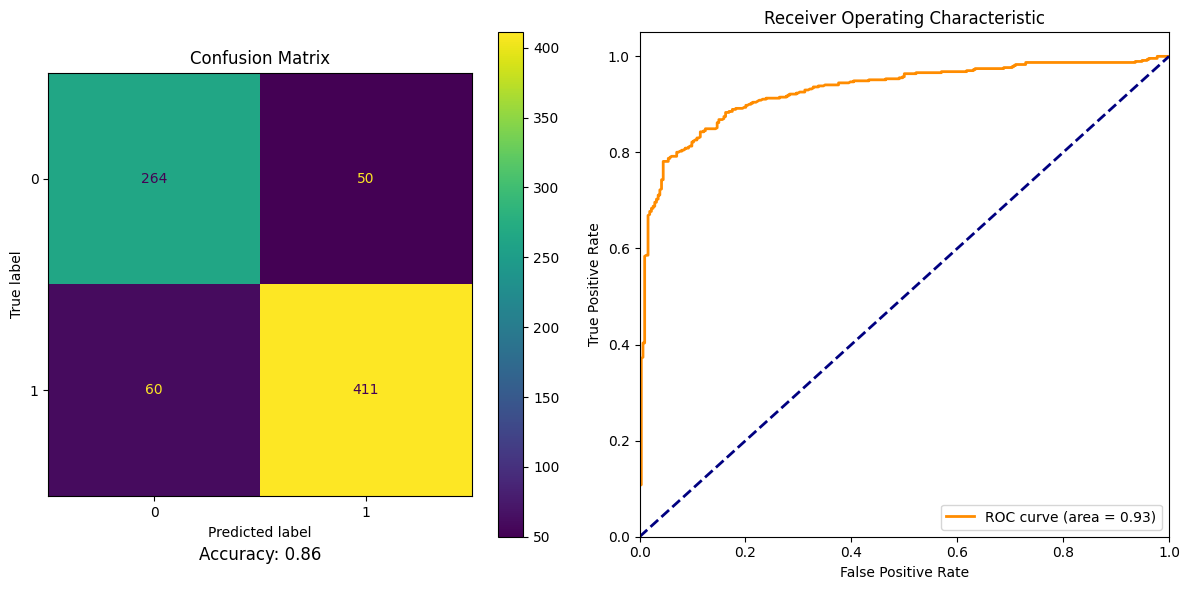

In [16]:
from catboost import CatBoostClassifier
import src.visualization.visualize as vis

model = CatBoostClassifier(iterations=300, learning_rate=0.1, logging_level='Silent')
model.fit(X_train_t1, y_train_t1)

vis.plot_model_performance(model, X_test_t1, y_test_t1, 'accuracy')

## Secondo test (ill)

In questo caso viene addestrato un modello che deve riconoscere i pazienti affetti da covid da quelli affetti da sepsi

In [35]:
import src.data.data_selection as ds

try:
    result_statistical_ill = significant_features_dict[('covid_Empoli_60', 'sepsis_MIMIC_125')]
except KeyError:
    result_statistical_ill = significant_features_dict[('sepsis_MIMIC_125', 'covid_Empoli_60')]
    
features_test_2 = result_statistical_ill[result_statistical_ill['P-value'] < 0.05]['Feature'].tolist() 

#features_test_2 = list(set(unified_result[unified_result['P-value'] > 0.05]['Feature'].tolist()).intersection(features_test_2))

X_train_t2 = X_train[features_test_2]
X_test_t2 = X_test[features_test_2]

# si rimuovono le righe relative ai gruppi 'healthyControl_Empoli_60' e 'mentalDisorders_MIMIC_125'
target_values = ['covid_Empoli_60', 'sepsis_MIMIC_125']
X_train_t2, y_train_t2 = ds.filter_rows_by_values(X_train_t2, y_train, target_values)
X_test_t2, y_test_t2 = ds.filter_rows_by_values(X_test_t2, y_test, target_values)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_t2_pca = pca.fit_transform(X_train_t2)
X_test_t2_pca = pca.transform(X_test_t2)



### Cross-validation

In [36]:
import src.models.model as models
import src.models.evaluation as ev

models = models.define_models()
metric_results = ev.evaluate_models(X_train_t2_pca, y_train_t2, models)

ev.summarize_results(metric_results)

Models Evaluation with f1_macro: 100%|██████████| 9/9 [00:11<00:00,  1.28s/it]
Models Evaluation with make_scorer(matthews_corrcoef, response_method='predict'): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


Metric: f1_macro
Rank=1, Name=mlp, Score=0.869 (+/- 0.019)
Rank=2, Name=rf, Score=0.858 (+/- 0.031)
Rank=3, Name=catboost, Score=0.856 (+/- 0.019)
Rank=4, Name=nb, Score=0.851 (+/- 0.027)
Rank=5, Name=svm, Score=0.851 (+/- 0.028)
Rank=6, Name=gbm, Score=0.845 (+/- 0.025)
Rank=7, Name=adaboost, Score=0.821 (+/- 0.021)
Rank=8, Name=dt, Score=0.814 (+/- 0.036)
Rank=9, Name=nc, Score=0.801 (+/- 0.028)

Metric: make_scorer(matthews_corrcoef, response_method='predict')
Rank=1, Name=rf, Score=0.741 (+/- 0.044)
Rank=2, Name=mlp, Score=0.735 (+/- 0.030)
Rank=3, Name=catboost, Score=0.724 (+/- 0.020)
Rank=4, Name=svm, Score=0.718 (+/- 0.040)
Rank=5, Name=nb, Score=0.714 (+/- 0.056)
Rank=6, Name=gbm, Score=0.710 (+/- 0.056)
Rank=7, Name=dt, Score=0.670 (+/- 0.049)
Rank=8, Name=adaboost, Score=0.656 (+/- 0.036)
Rank=9, Name=nc, Score=0.623 (+/- 0.047)


In [38]:
import src.models.evaluation as ev

ev.evaluate_optimized_models(X_train_t2_pca, y_train_t2, model_names=['mlp', 'catboost', 'rf'], metric='f1_macro', cv=5)

c:\Users\cical\Documents\GitHub\Repositories\tesina\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cical\Documents\GitHub\Repositories\tesina\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best hyperparameters for model mlp: {'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model mlp - Score=0.875 (+/- 0.015)
---------------------------------------------------------------
Best hyperparameters for model catboost: {'iterations': 100, 'learning_rate': 0.1}
Model catboost - Score=0.855 (+/- 0.019)
---------------------------------------------------------------
Best hyperparameters for model rf: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Model rf - Score=0.857 (+/- 0.028)
---------------------------------------------------------------


c:\Users\cical\Documents\GitHub\Repositories\tesina\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


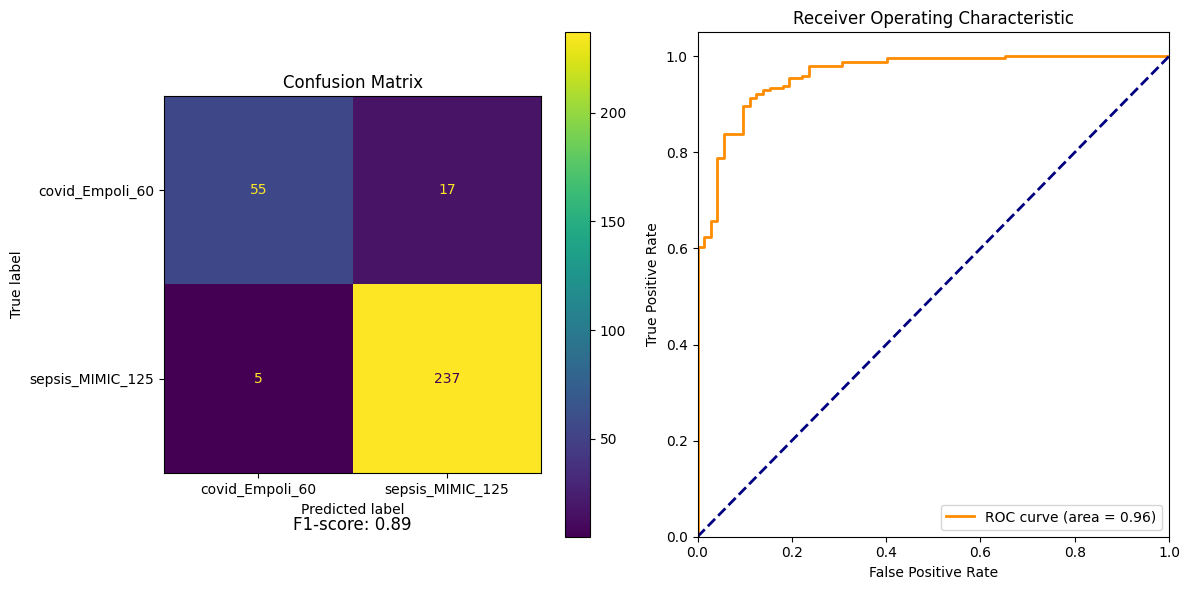

In [39]:
from sklearn.neural_network import MLPClassifier
import src.visualization.visualize as vis

model = MLPClassifier(alpha=0.01, hidden_layer_sizes=(50,))
model.fit(X_train_t2_pca, y_train_t2)

vis.plot_model_performance(model, X_test_t2_pca, y_test_t2, 'f1-score')

## Test 3 (Health)

Viene addestrato un modello con lo scopo di identificare i pazienti sani da quelli con disturbi mentali

In [41]:
import src.data.data_selection as ds

result_statistical_health = significant_features_dict[('mentalDisorders_MIMIC_125', 'healthyControl_Empoli_60')]
features_test_3 = result_statistical_health[result_statistical_health['P-value'] < 0.05]['Feature'].tolist()

#features_test_3 = list(set(unified_result[unified_result['P-value'] > 0.05]['Feature'].tolist()).intersection(features_test_3))

X_train_t3 = X_train[features_test_3]
X_test_t3 = X_test[features_test_3]

# si rimuovono le righe relative ai gruppi 'covid_Empoli_60' e 'sepsis_MIMIC_125'
target_values = ['mentalDisorders_MIMIC_125', 'healthyControl_Empoli_60']
X_train_t3, y_train_t3 = ds.filter_rows_by_values(X_train_t3, y_train, target_values)
X_test_t3, y_test_t3 = ds.filter_rows_by_values(X_test_t3, y_test, target_values)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_t3_pca = pca.fit_transform(X_train_t3)
X_test_t3_pca = pca.transform(X_test_t3)

### Cross-validation

In [42]:
import src.models.model as models
import src.models.evaluation as ev

models = models.define_models()
metric_results = ev.evaluate_models(X_train_t3_pca, y_train_t3, models)

ev.summarize_results(metric_results)

Models Evaluation with f1_macro: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]
Models Evaluation with make_scorer(matthews_corrcoef, response_method='predict'): 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]


Metric: f1_macro
Rank=1, Name=svm, Score=0.936 (+/- 0.048)
Rank=2, Name=catboost, Score=0.926 (+/- 0.041)
Rank=3, Name=rf, Score=0.922 (+/- 0.031)
Rank=4, Name=mlp, Score=0.921 (+/- 0.043)
Rank=5, Name=adaboost, Score=0.913 (+/- 0.035)
Rank=6, Name=gbm, Score=0.913 (+/- 0.029)
Rank=7, Name=nb, Score=0.894 (+/- 0.028)
Rank=8, Name=dt, Score=0.891 (+/- 0.036)
Rank=9, Name=nc, Score=0.875 (+/- 0.046)

Metric: make_scorer(matthews_corrcoef, response_method='predict')
Rank=1, Name=svm, Score=0.875 (+/- 0.096)
Rank=2, Name=catboost, Score=0.855 (+/- 0.083)
Rank=3, Name=rf, Score=0.854 (+/- 0.064)
Rank=4, Name=mlp, Score=0.852 (+/- 0.096)
Rank=5, Name=gbm, Score=0.832 (+/- 0.056)
Rank=6, Name=adaboost, Score=0.832 (+/- 0.069)
Rank=7, Name=nb, Score=0.803 (+/- 0.047)
Rank=8, Name=dt, Score=0.800 (+/- 0.066)
Rank=9, Name=nc, Score=0.762 (+/- 0.088)


In [43]:
import src.models.evaluation as ev

ev.evaluate_optimized_models(X_train_t3_pca, y_train_t3, model_names=['svm', 'mlp', 'catboost', metric='f1_macro', cv=5)

Best hyperparameters for model svm: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
Model svm - Score=0.934 (+/- 0.049)
---------------------------------------------------------------
Best hyperparameters for model mlp: {'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
Model mlp - Score=0.925 (+/- 0.056)
---------------------------------------------------------------
Best hyperparameters for model catboost: {'iterations': 100, 'learning_rate': 0.1}
Model catboost - Score=0.926 (+/- 0.039)
---------------------------------------------------------------


c:\Users\cical\Documents\GitHub\Repositories\tesina\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best hyperparameters for model adaboost: {'learning_rate': 0.5, 'n_estimators': 50}
Model adaboost - Score=0.922 (+/- 0.042)
---------------------------------------------------------------


c:\Users\cical\Documents\GitHub\Repositories\tesina\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


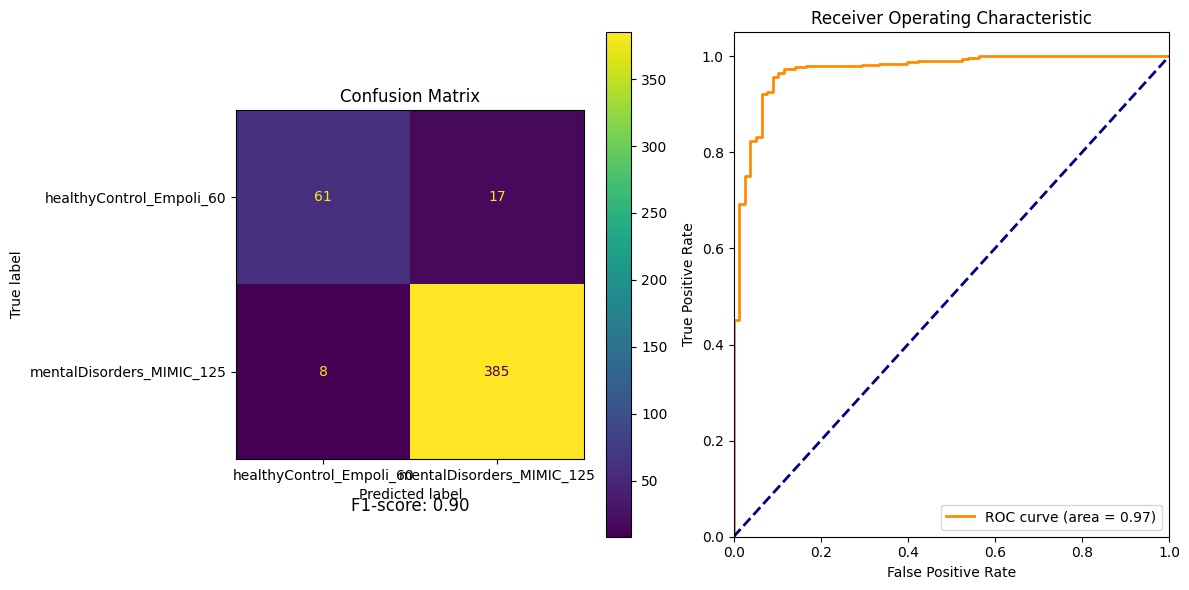

In [44]:
from sklearn.svm import SVC
import src.visualization.visualize as vis

model = SVC(C=10, gamma=0.1, kernel='rbf', probability=True)
model.fit(X_train_t3_pca, y_train_t3)

vis.plot_model_performance(model, X_test_t3_pca, y_test_t3, 'f1-score')

## Test 4 (All)

In [ ]:
features_test_4 = friedman_test[friedman_test['P-value'] < 0.05]['Feature'].tolist()

X_train_t4 = X_train[features_test_4]
X_test_t4 = X_test[features_test_4]

y_train_t4 = y_train
y_test_t4 = y_test

In [ ]:
import src.models.model as models
import src.models.evaluation as ev

models = models.define_models()
metric_results = ev.evaluate_models(X_train_t4, y_train_t4, models)

ev.summarize_results(metric_results)

In [ ]:
import src.models.evaluation as ev

ev.evaluate_optimized_models(X_train_t3, y_train_t3, model_names=['gbm', 'catboost', 'rf'], metric='f1_macro', cv=5)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import src.visualization.visualize as vis

model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model.fit(X_train_t3, y_train_t3)

vis.plot_model_performance(model, X_test_t3, y_test_t3, 'f1-score')